In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt

events = Events("CheatedRecoFile_10.root")
import os

events2 = Events("CheatedRecoFile_0.root")


ELECTRON_PDG_SET = {11, -11}  # Electron and positron PDG codes
PHOTON_PDG_SET = {22, -22}  # Photon PDG codes
shower_pdg_set = {11, -11, 22, -22} 

  Using cached uproot-5.5.1-py3-none-any.whl.metadata (33 kB)
  Using cached awkward-2.7.4-py3-none-any.whl.metadata (7.0 kB)
  Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached uproot-5.5.1-py3-none-any.whl (362 kB)
Using cached awkward-2.7.4-py3-none-any.whl (871 kB)
Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (638 kB)
Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)


In [2]:
def categorise_event(events, event_idx, shower_pdg_set):
    # Extract PDG code
    pdg_code = events.mc_pdg[event_idx]  # Assuming this holds a single PDG code
    
    # Determine if event is a shower or track
    if pdg_code in shower_pdg_set:
        return 'shower'
    else:
        return 'track'  # All other PDG codes are considered as track


def categorise_event_shower(events, event_idx):
    # Extract PDG code
    pdg_code = events.mc_pdg[event_idx]  
    
    # Classify as electron or photon
    if pdg_code in ELECTRON_PDG_SET:
        return 'electron'
    elif pdg_code in PHOTON_PDG_SET:
        return 'photon'
    else:
        return None  # Filter out track particles

Sum of normalized hist_electron (should be close to 1): 1.0
Sum of normalized hist_photon (should be close to 1): 1.0


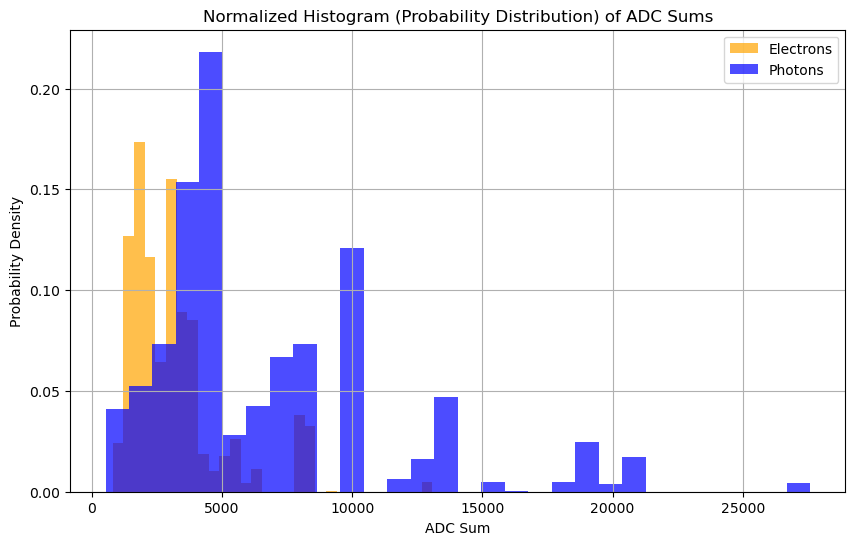

In [3]:
def process_event_and_plot_probability_distribution(events):
    adc_sum_electrons = []
    adc_sum_photons = []

    for event_index in range(len(events.event_number)):
        all_x_hits = []
        all_w_hits = []
        all_adc_values = []
        all_pdg_codes = []
        
        # Loop through sub-events for the specified event index
        sub_events = np.where(events.event_number == events.event_number[event_index])[0]
        for sub_event in sub_events:
            x_hits = events.reco_hits_x_w[sub_event]
            w_hits = events.reco_hits_w[sub_event]
            adc_values = events.reco_adcs_w[sub_event]
            pdg_code = events.mc_pdg[sub_event]
            
            # Append hits to the corresponding lists
            all_x_hits.extend(x_hits)
            all_w_hits.extend(w_hits)
            all_adc_values.extend(adc_values)
            all_pdg_codes.extend(np.full(len(x_hits), pdg_code))

        # Convert hits to numpy arrays
        all_x_hits = np.array(all_x_hits)
        all_w_hits = np.array(all_w_hits)
        all_adc_values = np.array(all_adc_values)
        all_pdg_codes = np.array(all_pdg_codes)

        # Identify the particle with the most hits
        unique_particles, counts = np.unique(all_pdg_codes, return_counts=True)
        most_hits_particle_code = unique_particles[np.argmax(counts)]

        # Skip events where the most-hit particle has less than 15 hits
        if counts[np.argmax(counts)] < 15:
            continue

        # Filter hits for the most-hit particle
        most_hit_indices = np.where(all_pdg_codes == most_hits_particle_code)[0]
        distances_to_vertex = np.sqrt(
            (all_x_hits[most_hit_indices] - events.neutrino_vtx_x[event_index])**2 +
            (all_w_hits[most_hit_indices] - events.neutrino_vtx_w[event_index])**2
        )
        closest_hit_index = most_hit_indices[np.argmin(distances_to_vertex)]
        first_hit_x = all_x_hits[closest_hit_index]
        first_hit_w = all_w_hits[closest_hit_index]

        # Calculate ADC sum for hits of the most-hit particle within 5cm of the closest hit
        adc_sum_inside_circle = 0
        hits_within_5cm = 0  # Initialize counter for hits within 5cm

        # Calculate distances and check the condition
        for i in range(len(all_w_hits)):
            distance = np.sqrt((all_w_hits[i] - first_hit_w)**2 + (all_x_hits[i] - first_hit_x)**2)

            # Only count hits from the same particle type
            if distance <= 5 and all_pdg_codes[i] == most_hits_particle_code:
                hits_within_5cm += 1  # Count the hit
                adc_sum_inside_circle += all_adc_values[i]

        # Apply threshold: if there are fewer than 3 hits within 5cm, skip the event
        if hits_within_5cm < 5:
            continue

        # Store the ADC sum based on the particle type
        if most_hits_particle_code == 11:  # Electron
            adc_sum_electrons.append(adc_sum_inside_circle)
        elif most_hits_particle_code == 22:  # Photon
            adc_sum_photons.append(adc_sum_inside_circle)

   # Define shared bin edges for both histograms
    if adc_sum_electrons or adc_sum_photons:
        combined_adc_sums = adc_sum_electrons + adc_sum_photons
        hist_electron, bin_edges_electron = np.histogram(adc_sum_electrons, bins=30, density=True)
        hist_photon, bin_edges_photon = np.histogram(adc_sum_photons, bins=30, density=True)

        bin_widths_electron = np.diff(bin_edges_electron)
        bin_widths_photon = np.diff(bin_edges_photon)

        hist_electron_normalized = hist_electron * bin_widths_electron
        hist_photon_normalized = hist_photon * bin_widths_photon

        print(f"Sum of normalized hist_electron (should be close to 1): {np.sum(hist_electron_normalized)}")
        print(f"Sum of normalized hist_photon (should be close to 1): {np.sum(hist_photon_normalized)}")

        # Plot normalized histograms
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges_electron[:-1], hist_electron_normalized, width=bin_widths_electron, alpha=0.7, label="Electrons", color='orange', align='edge')
        plt.bar(bin_edges_photon[:-1], hist_photon_normalized, width=bin_widths_photon, alpha=0.7, label="Photons", color='blue', align='edge')
        plt.xlabel("ADC Sum")
        plt.ylabel("Probability Density")
        plt.title("Normalized Histogram (Probability Distribution) of ADC Sums")
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("No valid events to plot.")

process_event_and_plot_probability_distribution(events)


In [5]:
def find_radial_density_increase(x, y, bins=50, center=None, start_radius=0, debug=False):
    """Finds the first radial distance where point density increases noticeably, ignoring inner regions."""
    if center is None:
        center = (np.mean(x), np.mean(y))  # Default to centroid
    
    # Compute radial distances
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    # Filter out points inside the start_radius
    r = r[r > start_radius]
    
    if len(r) == 0:
        return None  # No points outside start_radius
    
    # Sort distances
    r_sorted = np.sort(r)
    
    # Bin distances into radial shells
    bin_edges = np.linspace(start_radius, max(r_sorted), bins)
    counts, _ = np.histogram(r_sorted, bins=bin_edges)
    
    # Compute density (points per unit radial area)
    areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)  # Area of each shell
    densities = counts / areas  # Normalize by area
    
    # Find the first significant density increase
    diffs = np.diff(densities)  # First derivative
    increase_idx = np.argmax(diffs > 0)  # First increase in density
    
    if increase_idx == 0 and diffs[0] <= 0:
        return None  # No clear increase found
    
    return bin_edges[increase_idx]

def dEdx_points3(events, event_idx, cone_angle, show_plot=False, debug=False):
    w_hits = events.reco_hits_w[event_idx]

    # Quality Check
    if not len(w_hits) > 15:
        print('Does not meet 15 hit cutoff')
        return None
        
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]
    adcs = events.reco_adcs_w[event_idx]
    
    pdg = events.mc_pdg[event_idx]
    c_class = 'b'
    event = 'ERROR: Not e/gamma'
    
    if pdg in [-11, 11]:
        c_class = '#EEEE00'
        event = 'Electron'
    elif pdg == 22:
        c_class = 'g'
        event = 'Photon'
    else: print(event)

    if debug:
        print(f'event = {event}')

    # make the validity cone
    direction = np.sign(np.mean(w_hits) - w_vtx)

    if direction == -1:
        w_hits = 2 * w_vtx - np.array(w_hits)
        if debug:
            print(f'Event {event_idx} was left-facing, and has been inverted')

    slope, _ = np.polyfit(w_hits, x_hits, 1)
    theta_0 = np.arctan2(slope, 1)
    theta_u = theta_0 + (cone_angle/2)
    theta_l = theta_0 - (cone_angle/2)

    angles = np.arctan2(x_hits - x_vtx, w_hits - w_vtx)
    distance = [np.sqrt((w - w_vtx)**2 + (x - x_vtx)**2) for w, x in zip(w_hits, x_hits)]

    r_start = 5
    if len(distance) >= 5:
        r_start = sorted(distance)[4]
    
    testing_distance = find_radial_density_increase(w_hits, x_hits, center = (w_vtx, x_vtx), start_radius = r_start)

    branch_distance = max(r_start + 5, testing_distance)
    
    mask = (angles >= theta_l) & (angles <= theta_u) & (distance < branch_distance)

    if not show_plot:
        return w_hits[mask], x_hits[mask], adcs[mask]

    # Compute line endpoints
    w_u = w_vtx + 30 * np.cos(theta_u)
    x_u = x_vtx + 30 * np.sin(theta_u)
    
    w_l = w_vtx + 30 * np.cos(theta_l)
    x_l = x_vtx + 30 * np.sin(theta_l)
    
    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns
    ax[0].scatter(w_vtx, x_vtx, c='r', marker='x', s=35, label='Neutrino vtx')
    # Event plot
    ax[0].scatter(w_hits, x_hits, s=3, c=c_class, label=f'{event} Hits')
    
    # Plot the lines
    ax[0].plot([w_vtx, w_u], [x_vtx, x_u], 'r--')  # Upper line
    ax[0].plot([w_vtx, w_l], [x_vtx, x_l], 'b--', label='Angle Bound')  # Lower line
    ax[0].set_title(f'Noise Reduction Plot; idx: {event_idx}. Event is a {event}')
    ax[0].set_ylabel('X (W View)')
    ax[0].set_xlabel('W (Wire Position)')
    ax[0].legend()
    ax[0].grid(True)

    ax[1].scatter(w_vtx, x_vtx, c='r', marker='x', s=25, label='Neutrino vtx')
    ax[1].scatter(w_hits, x_hits, s=3, c='grey', label='Hits')
    ax[1].scatter(w_hits[mask], x_hits[mask], s=5, c='purple', label='Identified Points')
    ax[1].legend()
    ax[1].grid(True)

    return w_hits[mask], x_hits[mask], adcs[mask]

In [7]:
# new feature histogram function